###Neste notebook irei adicionar tudo o que foi aprendido durante todo o curso de ciência de dados, a base com que estarei trabalhando já foi realizado o PCA, então não será necessário uma análise exploratória ou visualização gráfica. Será exclusivo de encontrar o melhor modelo e hiperparâmetros para ajustar a percepção do modelo para esta base que está extremamente desbalanceada. Desta forma será possível prever a pequena taxa de fraudes em transações no cartão de crédito.

---
Farei a importação das bibliotecas


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier

Vamos carregar a base em nosso notebook

In [ ]:
df = pd.read_csv('/content/Base_M43_Pratique_CREDIT_CARD_FRAUD.csv')

In [ ]:
df.head (5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Como neste modelo escolhi já trabalhar com o XGBoost a variável target ser 'int64' não necessita de tratamento, o modelo se adequa melhor desta forma.
---
Farei a separação de treino e teste

In [ ]:
target_col = 'Class'
X = df.drop(target_col, axis=1)
y = df[target_col]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Apesar de já ter sido informado sobre o percentual de fraudes irei fazer a verificação:

In [ ]:
nao_fraude_count_train = y_train.value_counts()[0]
fraude_count_train = y_train.value_counts()[1]
total_train = len(y_train)

# Percentual
percentual_fraude = (fraude_count_train / total_train) * 100

Farei a utilização do scale_pos_weight_value para adicionar o peso que nosso modelo deve dar para as fraudes que são muito baixas

In [ ]:
scale_pos_weight_value = nao_fraude_count_train / fraude_count_train

print(f"Total de Treino: {total_train}")
print(f"Fraudes (1): {fraude_count_train}")
print(f"Percentual de Fraudes: {percentual_fraude:.4f}%")
print("-" * 40)
print(f"Scale Pos Weight (peso para Fraudes): {scale_pos_weight_value:.2f}")
print("-" * 40)

Total de Treino: 227845
Fraudes (1): 394
Percentual de Fraudes: 0.1729%
----------------------------------------
Scale Pos Weight (peso para Fraudes): 577.29
----------------------------------------


In [ ]:
scale_pos_weight_value = 577.29

Após definido o peso da classe com sua escala utilizando scale_pos_weight, farei o treinamento do modelo com diversos hiperparâmetros que foram aprendidos, no meio disto adicionarei o peso da variável target que queremos prever desta forma podendo fazer previsões mais acertivas.
Inicialmente farei testes, pois acredito que farei a utilização de um GridSearch

In [ ]:
xgb_model = XGBClassifier(
    objective='binary:logistic',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    scale_pos_weight=scale_pos_weight_value, #O valor 577.29 é aplicado aqui
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

1. **objective='binary:logistic'Função:** Define a função de perda (ou loss function) a ser minimizada.Impacto: Neste caso, indica que estamos fazendo uma classificação binária (duas classes: 0 e 1) e que o modelo deve produzir as probabilidades da amostra pertencer à classe positiva (fraude), usando a função logística (sigmoid).
2. **n_estimators= 500 Função:** O número de árvores de decisão sequenciais (boosted trees) que o modelo construirá.Impacto: Um número maior geralmente leva a um modelo mais preciso, mas aumenta o tempo de treinamento e o risco de overfitting (ajustar-se demais aos dados de treino). Escolhemos 500 como um bom ponto de partida, mas isso seria otimizado em um Grid Search.
3. **learning_rate=0.05Função:** Controla o quão rapidamente o modelo aprende. É o peso aplicado à contribuição de cada nova árvore de decisão.Impacto: Um valor pequeno (como $0.05$ ou até $0.01$) torna o aprendizado mais lento e cauteloso, exigindo mais árvores (n_estimators), mas geralmente resulta em um modelo final mais robusto e menos propenso ao overfitting do que um valor alto (e.g., $0.3$).
4. **max_depth=5 Função:** A profundidade máxima que cada árvore de decisão individual pode ter.Impacto: Controla a complexidade do modelo. Uma profundidade maior permite que o modelo capture interações mais complexas nos dados, mas também aumenta o risco de overfitting. Um valor de 5 é um bom equilíbrio, especialmente em bases pós-PCA, onde a dimensionalidade já foi reduzida.
5. **scale_pos_weight= 577.29 Função:** Este é o peso que o modelo deve dar às amostras da classe positiva (fraude) em relação às amostras da classe negativa (não-fraude).Impacto: Essencial para bases desbalanceadas. Como há $\approx 577$ não-fraudes para cada fraude na base de treino, ao definir o peso como $577.29$, forçamos o modelo a penalizar os Falsos Negativos (perder uma fraude) 577 vezes mais do que os Falsos Positivos. Isso é fundamental para aumentar o Recall.$$\text{scale_pos_weight} = \frac{\text{Número de Não-Fraudes}}{\text{Número de Fraudes}}$$
6. **use_label_encoder=FalseFunção:** Desabilita um recurso de codificação interna de labels que será descontinuado em versões futuras do XGBoost.Impacto: Não tem impacto no desempenho do modelo, mas é uma boa prática para evitar warnings e garantir compatibilidade futura.
7. **eval_metric='logloss'Função:** Define a métrica usada para medir o desempenho do modelo em cada iteração (durante o treinamento).Impacto: logloss (perda logarítmica) é a métrica padrão e é ideal para classificação baseada em probabilidade, pois penaliza previsões erradas com alta confiança.
8. **random_state=42Função:** Garante que todas as operações aleatórias (como a construção das árvores) sejam reproduzíveis.Impacto: Fixa a "semente" da aleatoriedade, garantindo que você obtenha exatamente o mesmo resultado toda vez que executar o código, o que é vital para depuração e comparação de modelos.
9. **n_jobs=-1Função:** Indica o número de núcleos de processamento que o XGBoost pode usar.Impacto: Usar -1 significa que o modelo usará todos os núcleos disponíveis em sua máquina. Isso acelera drasticamente o tempo de treinamento, especialmente com bases grandes e alto n_estimators.

In [ ]:
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:13:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=-1,
              num_parallel_tree=None, ...)

In [ ]:
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Métricas de Avaliação
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [ ]:
print("Resultados da Avaliação Inicial (Threshold 0.5)")
print(f"AUC-ROC: {roc_auc:.4f}")
print(f"Recall (Detecção de Fraude): {recall:.4f}")
print(f"Precision: {precision:.4f}")
print("-" * 40)
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(cm)
print(f"\nFalsos Negativos: {cm[1, 0]}")

Resultados da Avaliação Inicial (Threshold 0.5)
AUC-ROC: 0.9743
Recall (Detecção de Fraude): 0.8367
Precision: 0.8542
----------------------------------------
Matriz de Confusão:
[[56850    14]
 [   16    82]]

Falsos Negativos: 16


São ótimos resultados inicias, obtivemos 83% de Recall e 85% de precisão de 82 fraudes ele errou apenas 16 que são os falsos negativos, agora afim de fazer um ajuste maior em nosso modelo farei a plotagem do gráfico de nossa curva com precision e recall

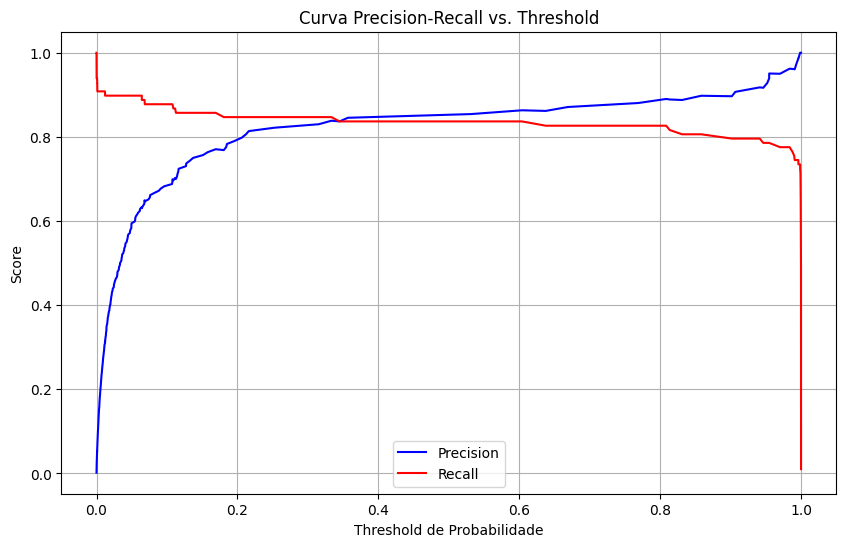

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='red')
plt.title('Curva Precision-Recall vs. Threshold')
plt.xlabel('Threshold de Probabilidade')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

Acredito que neste momento devemos priorizar nosso Recall então farei ajustes onde nossa precisão irá cair, porém nosso recall subirá de forma significativa, devo ter cautela por conta que a prioridade no quesito de fraude é a segurança

In [ ]:
from sklearn.metrics import make_scorer, recall_score
recall_scorer = make_scorer(recall_score)

In [ ]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 500, 1000]
}

In [ ]:
from sklearn.model_selection import GridSearchCV
xgb_base = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=577.29,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring=recall_scorer, # Otimizando para o Recall
    cv=3,
    verbose=2,
    n_jobs=-1
)

In [ ]:
grid_search.fit(X_train, y_train)
print("\nMelhores Hiperparâmetros encontrados:")
print(grid_search.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:44:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Melhores Hiperparâmetros encontrados:
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


Após encontrarmos os melhores hiperparâmetros realizaremos o ultimo treinamento para ver como o modelo se sai

In [ ]:
optimized_threshold = 0.1

final_xgb_model = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=577.29,
    learning_rate=0.01,      # Otimizado
    max_depth=3,             # Otimizado
    n_estimators=200,        # Otimizado
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

In [ ]:
final_xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:51:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, ...)

In [ ]:
y_pred_proba_final = final_xgb_model.predict_proba(X_test)[:, 1]

y_pred_final = (y_pred_proba_final >= optimized_threshold).astype(int)

final_recall = recall_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final)
final_roc_auc = roc_auc_score(y_test, y_pred_proba_final)
final_cm = confusion_matrix(y_test, y_pred_final)

In [ ]:
print("\n Resultados FINAIS (Modelo Otimizado + Threshold 0.1)")
print(f"AUC-ROC: {final_roc_auc:.4f}")
print(f"Recall (Captura de Fraudes): {final_recall:.4f}")
print(f"Precision (Acurácia das Previsões): {final_precision:.4f}")
print("-" * 40)

print("Matriz de Confusão:")
print(final_cm)
print(f"\nFalsos Negativos (Fraudes Perdidas): {final_cm[1, 0]}")
print(f"Falsos Positivos (Alertas Falsos): {final_cm[0, 1]}")


 Resultados FINAIS (Modelo Otimizado + Threshold 0.1)
AUC-ROC: 0.9736
Recall (Captura de Fraudes): 0.9796
Precision (Acurácia das Previsões): 0.0037
----------------------------------------
Matriz de Confusão:
[[30776 26088]
 [    2    96]]

Falsos Negativos (Fraudes Perdidas): 2
Falsos Positivos (Alertas Falsos): 26088


Trabalhando com o threshhold 1 tivemos uma boa respostas quanto a falsos negativos porém os falsos positivos aumentaram muito o que é ruim já que o valor se aproxima do total, farei a alteração trabalhando com o treshhold em 3 que seria mais balanceado, já que nossa precisão está bem baixa também. O objetivo é manter a quantidade de falsos negativos, mas aumentando a precisão, pois dessa forma não teremos uma gama tão grande de falsos positivos

In [ ]:
compromise_threshold = 0.3

# Predição com o Threshold de Compromisso (0.3)
y_pred_compromise = (y_pred_proba_final >= compromise_threshold).astype(int)

# Métricas de Avaliação
cm_compromise = confusion_matrix(y_test, y_pred_compromise)
recall_compromise = recall_score(y_test, y_pred_compromise)
precision_compromise = precision_score(y_test, y_pred_compromise)

print("Resultados com Threshold de Compromisso (0.3)")
print(f"Recall (Captura de Fraudes): {recall_compromise:.4f}")
print(f"Precision (Acurácia das Previsões): {precision_compromise:.4f}")
print("-" * 40)

print("Matriz de Confusão:")
print(cm_compromise)
print(f"\nFalsos Negativos (FN - Fraudes Perdidas): {cm_compromise[1, 0]}")
print(f"Falsos Positivos (FP - Alertas Falsos): {cm_compromise[0, 1]}")

### Resultados com Threshold de Compromisso (0.3) ###
Recall (Captura de Fraudes): **0.9286**
Precision (Acurácia das Previsões): 0.0258
----------------------------------------
Matriz de Confusão:
[[53424  3440]
 [    7    91]]

Falsos Negativos (FN - Fraudes Perdidas): 7
Falsos Positivos (FP - Alertas Falsos): 3440


Podemos finalizar assim nosso modelo por enquanto, o modelo responde bem aos falsos negativos e diminuiu muito a gama de falsos positivos. É uma base que em um caso real deveria ganhar um acompanhamento minuncioso quanto aos dados novos que seriam recebidos, para realizar ajustes melhores, principalmente com o balanceamento. Podemos dizer que no âmbito dos négocios ele está bem, já que é melhor pecar pela sobra do que pela falta, se o modelo tem baixa taxa de falsos positivos e um recall de 92,86% para falsos negativos isso nos mostra que ele responde bem pra aquilo que foi programado. Na ideia de notificar pessoas sobre a possibilidade de fraudes mesmo que não seja uma fraude, isso faz até mesmo com que as pessoas se concientizem sobre onde realizam suas compras com o cartão.